**TODO**: 
- Apply logistic regression.
- Improve the imputer to use NNs.

## TPS August 2022


**Objective**: Given a product especifications, predict if it will fail or not.

## Notebook Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

from IPython.core.interactiveshell import InteractiveShell

pd.options.display.max_columns = None
InteractiveShell.ast_node_interactivity = "all"
sns.set_theme(style="darkgrid")

train_path = "data/train.csv"
test_path = "data/test.csv"
sample_sub_path = "data/sample_submission.csv"


## EDA

In [2]:
train = pd.read_csv(train_path, index_col="id")
test = pd.read_csv(test_path, index_col="id")


In [3]:
train.head()
test.head()


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,,,,
26570,F,119.57,material_5,material_6,6,4,6,9,6,19.305,10.178,17.534,18.168,11.598,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
26571,F,113.51,material_5,material_6,6,4,11,8,0,17.883,11.927,17.228,16.033,11.179,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
26572,F,112.16,material_5,material_6,6,4,8,12,4,18.475,10.481,16.619,18.189,12.126,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
26573,F,112.72,material_5,material_6,6,4,8,11,10,16.518,10.888,15.293,18.592,11.304,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
26574,F,208.00,material_5,material_6,6,4,14,16,8,17.808,12.693,17.678,15.814,13.431,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [4]:
train.shape
test.shape


(26570, 25)

(20775, 24)

In [5]:
train.dtypes


product_code       object
loading           float64
attribute_0        object
attribute_1        object
attribute_2         int64
attribute_3         int64
measurement_0       int64
measurement_1       int64
measurement_2       int64
measurement_3     float64
measurement_4     float64
measurement_5     float64
measurement_6     float64
measurement_7     float64
measurement_8     float64
measurement_9     float64
measurement_10    float64
measurement_11    float64
measurement_12    float64
measurement_13    float64
measurement_14    float64
measurement_15    float64
measurement_16    float64
measurement_17    float64
failure             int64
dtype: object

### Missing values:

<AxesSubplot:>

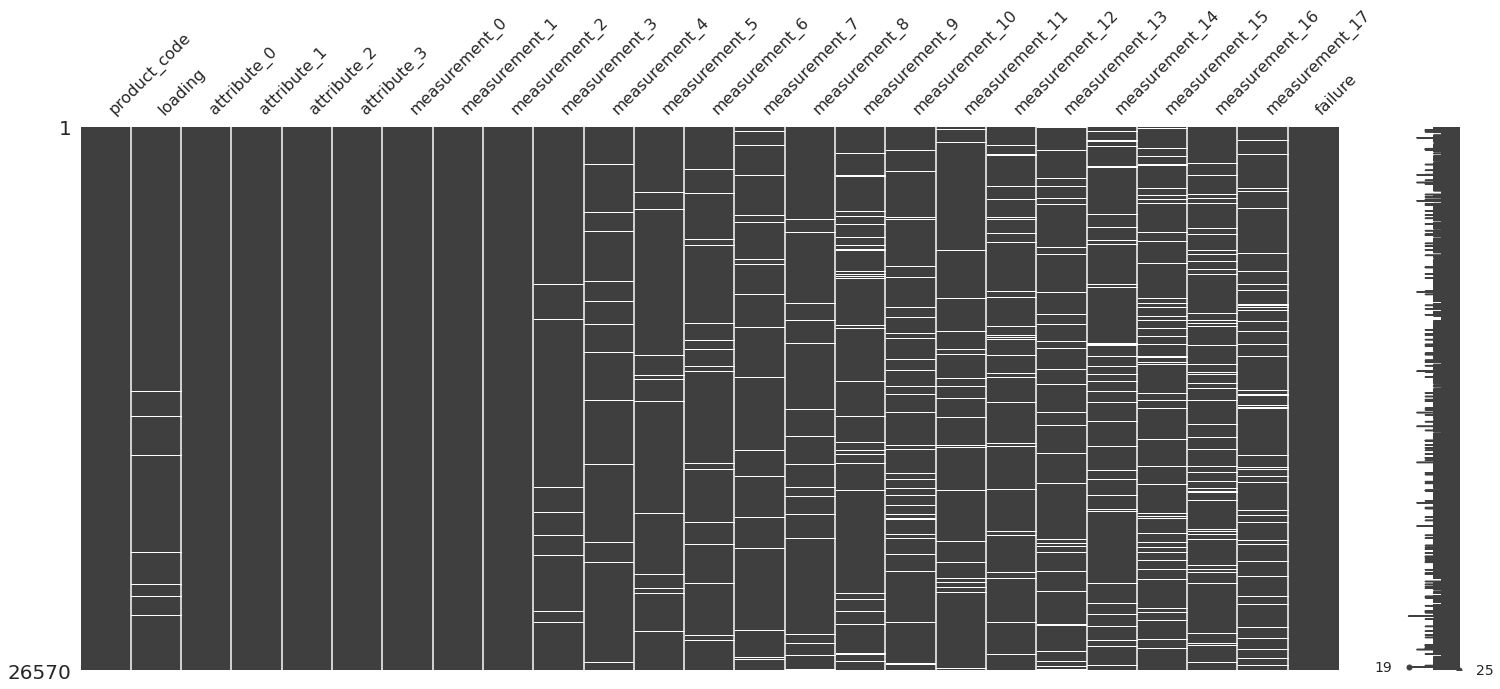

In [6]:
msno.matrix(train)


<Figure size 1080x432 with 0 Axes>

<AxesSubplot:>

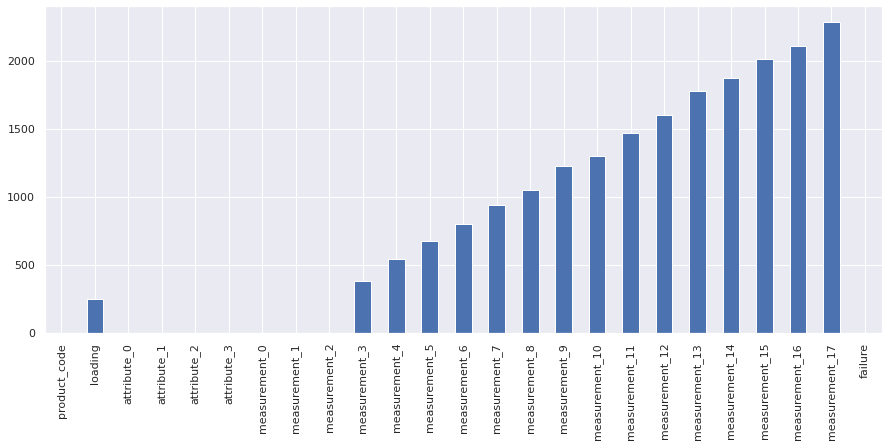

In [7]:
plt.figure(figsize=(15, 6))
train.isnull().sum().plot(kind="bar")
plt.show()


<AxesSubplot:>

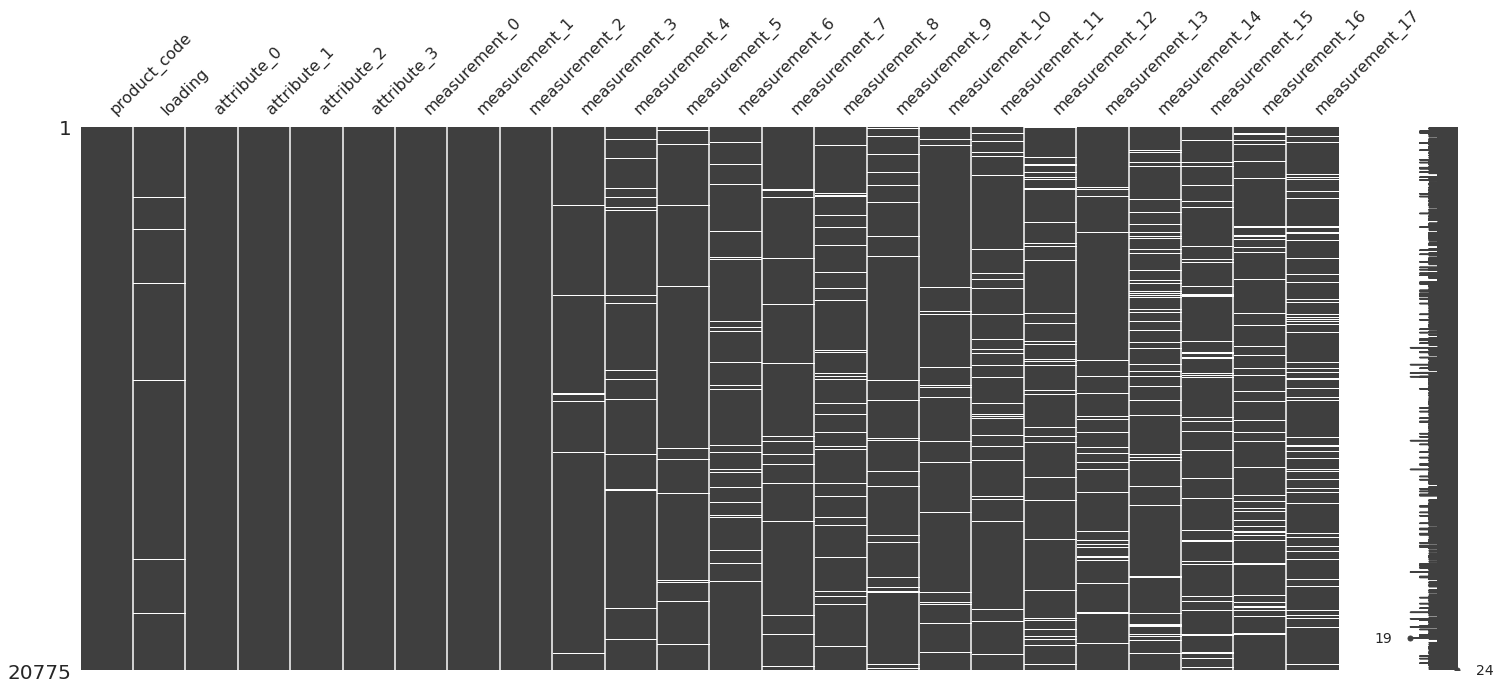

In [8]:
msno.matrix(test)


### Univariate analysis

Product codes: 

Text(0.5, 1.0, 'Product codes')

<AxesSubplot:title={'center':'Product codes'}, xlabel='product_code', ylabel='Counts'>

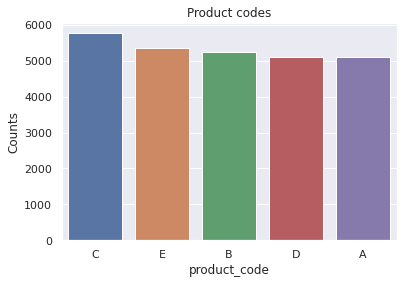

In [9]:
plt.title("Product codes")
sns.barplot(
    x="product_code",
    y="Counts",
    data=train["product_code"]
    .value_counts()
    .rename("Counts")
    .reset_index()
    .rename(columns={"index": "product_code"}),
)


Relationship between `product_code` and product `failure`:

In [10]:
pd.crosstab(
    index=train["product_code"],
    columns=[train["failure"]],
    margins=True,
    normalize=True,
)


failure,0,1,All
product_code,,,
A,0.148325,0.043621,0.191946
B,0.157998,0.039594,0.197591
C,0.171058,0.045916,0.216974
D,0.150546,0.041852,0.192397
E,0.159466,0.041626,0.201091
All,0.787392,0.212608,1.000000


In [11]:
InteractiveShell.ast_node_interactivity = "last_expr"


Integer columns

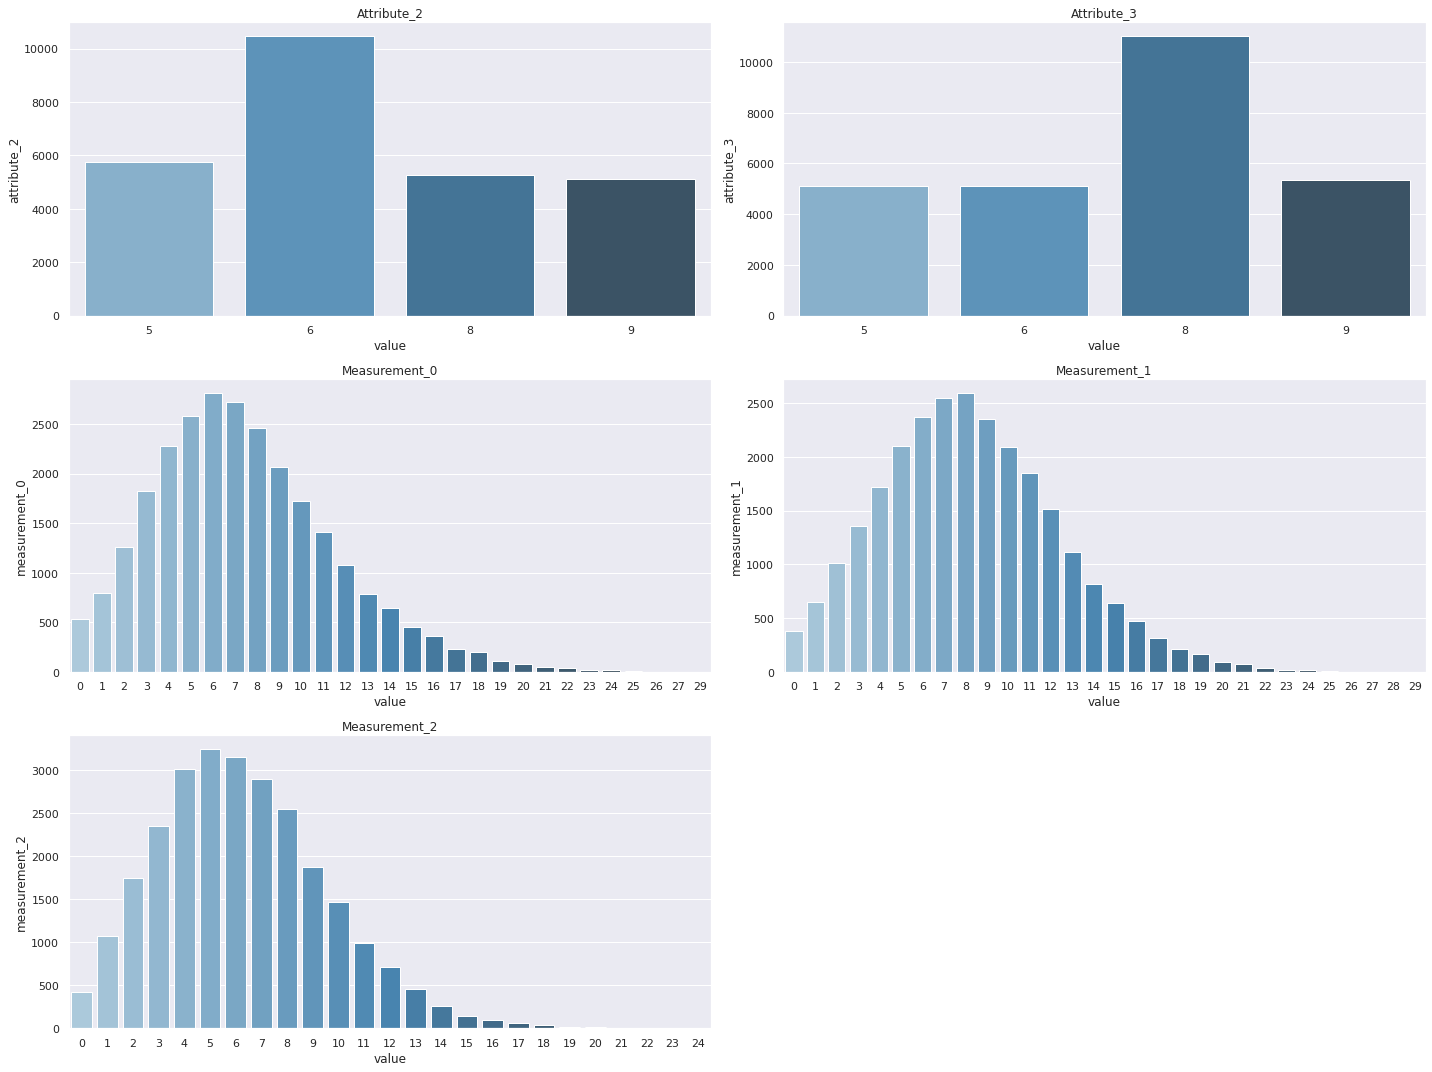

In [12]:
plt.figure(figsize=(20, 15))
int_cols = train.select_dtypes(int).drop(columns=["failure"]).columns
for idx, int_col in enumerate(int_cols):
    plt.subplot(3, 2, idx + 1)
    plt.title(f"{int_col.capitalize()}")
    data = (
        train[int_col].value_counts().reset_index().rename(columns={"index": "value"})
    )
    sns.barplot(x="value", y=int_col, data=data, palette="Blues_d")
    plt.tight_layout()


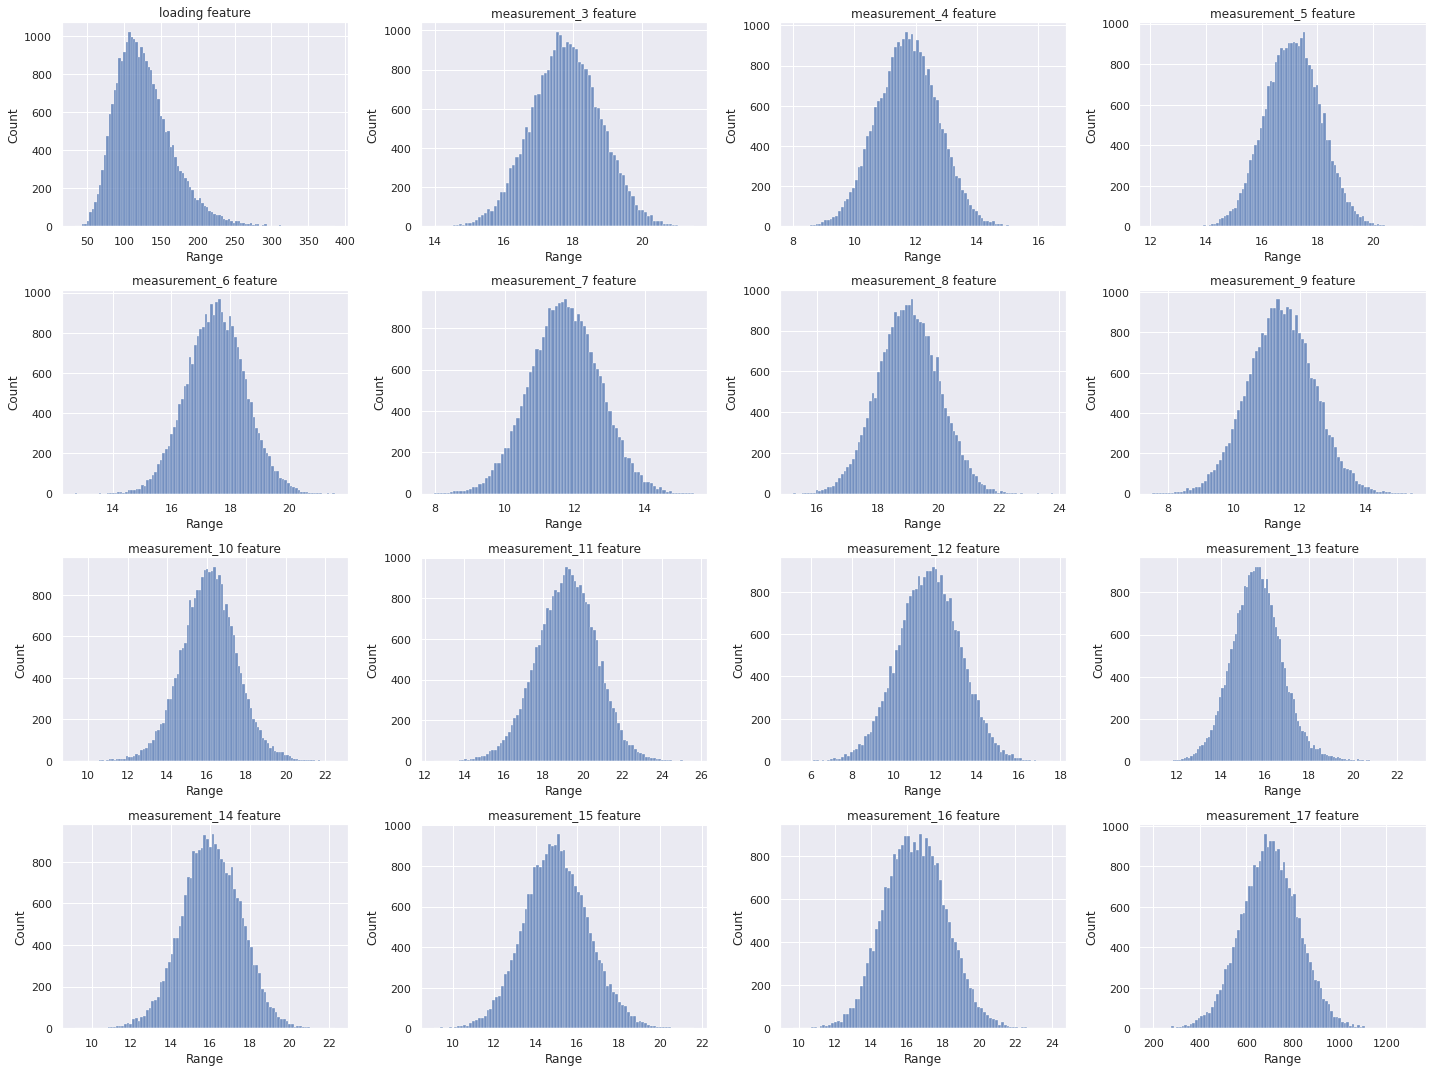

In [13]:
cont_cols = train.select_dtypes(float).columns

plt.figure(figsize=(20, 15))
for idx, col in enumerate(cont_cols):
    plt.subplot(4, 4, idx + 1)
    plt.title(f"{col} feature")
    sns.histplot(x=train[col].rename("Range"))
    plt.tight_layout()


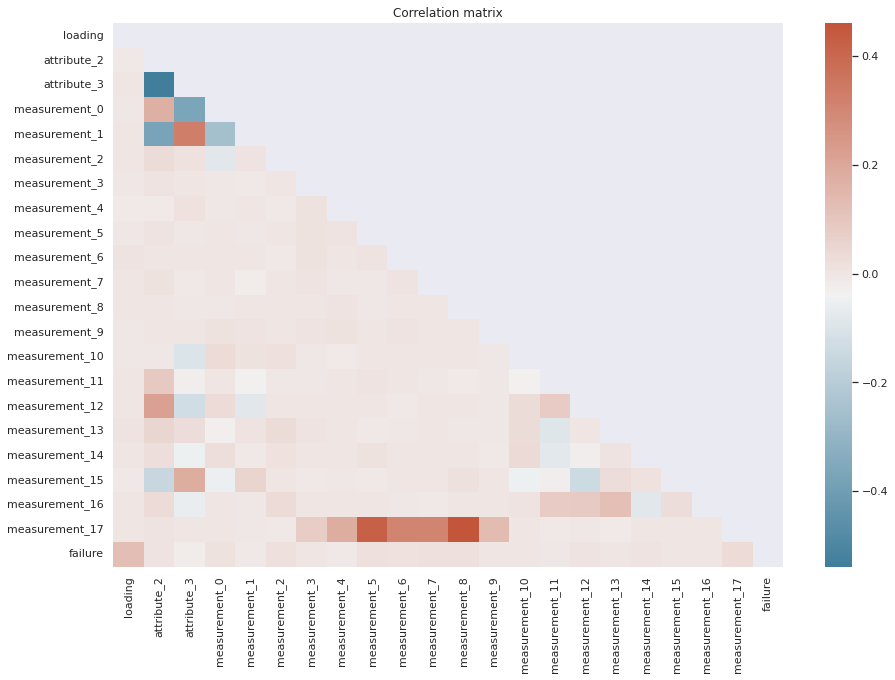

In [26]:
plt.figure(figsize=(15, 10))
mask = np.triu(np.ones_like(train.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.title("Correlation matrix")
sns.heatmap(train.corr(), mask=mask, cmap=cmap)
plt.show()


## Data cleaning

Used a SimpleImputer to handle the missing values:

In [15]:
train = pd.read_csv(train_path, index_col="id")
test = pd.read_csv(test_path, index_col="id")

null_cols = train.columns[train.isnull().any()]
imp = SimpleImputer(strategy="mean").fit(pd.concat([train[null_cols], test[null_cols]]))

train[null_cols] = imp.transform(train[null_cols])
test[null_cols] = imp.transform(test[null_cols])


## Model formulation and evaluation

In [48]:
features = [
    # "product_code",
    "loading",
    # "attribute_0",
    # "attribute_1",
    # "attribute_2",
    # "attribute_3",
    # "measurement_0",
    # "measurement_1",
    # "measurement_2",
    # "measurement_3",
    # "measurement_4",
    # "measurement_5",
    # "measurement_6",
    # "measurement_7",
    # "measurement_8",
    # "measurement_9",
    # "measurement_10",
    # "measurement_11",
    # "measurement_12",
    # "measurement_13",
    # "measurement_14",
    # "measurement_15",
    # "measurement_16",
    # "measurement_17",
]


def train_logit(features):
    X = train[features]
    y = train["failure"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=0
    )

    # fit logistig regression and calculate fpr, tpr, and auc
    logit = LogisticRegression(penalty="l2")
    y_score = logit.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # plot ROC
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=f"ROC curve (area = {roc_auc:.7f})",
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

    return logit


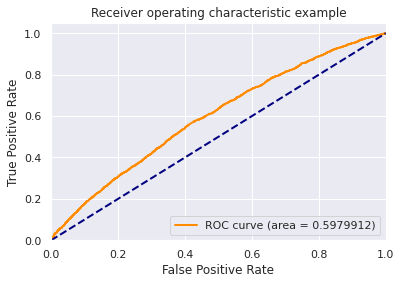

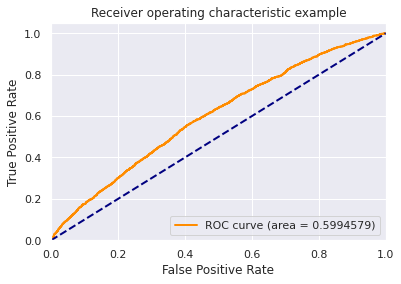

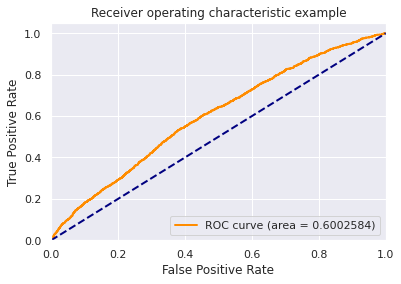

LogisticRegression()

In [49]:
train_logit(["loading"])
train_logit(["loading", "measurement_17"])
train_logit(["loading", "measurement_17", "measurement_2"])


## Submission

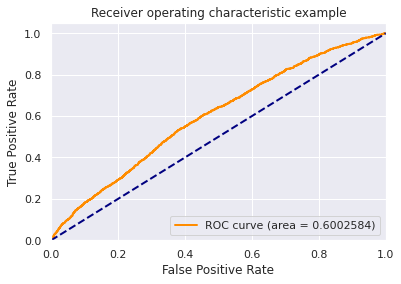

In [54]:
# predict failures
logit = train_logit(["loading", "measurement_17", "measurement_2"])
pred = logit.predict_proba(test[["loading", "measurement_17", "measurement_2"]])[:, 1]

# save predictions to csv
sub = pd.read_csv(sample_sub_path)
sub["failure"] = pred
sub.to_csv("submissions/Logit_3fts.csv", index=False)
